# Fit Exposure MF with hierarchical per-item $\mu_i$ to the binarized taste profile dataset

In [1]:
import glob
import os
# if you are using OPENBLAS, you might want to turn this option on. Otherwise, joblib might get stuck
# os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse
import pandas as pd

import rec_eval

In [2]:
import expomf

Change this to wherever you saved the processed data from [processTasteProfile.ipynb](processTasteProfile.ipynb)

In [3]:
DATA_ROOT = '/home/waldorf/dawen.liang/data/tasteprofile/'

In [4]:
unique_uid = list()
with open(os.path.join(DATA_ROOT, 'unique_uid_sub.txt'), 'r') as f:
    for line in f:
        unique_uid.append(line.strip())
    
unique_sid = list()
with open(os.path.join(DATA_ROOT, 'unique_sid_sub.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

In [5]:
n_songs = len(unique_sid)
n_users = len(unique_uid)

## Load the data and train the model

In [6]:
def load_data(csv_file, shape=(n_users, n_songs)):
    tp = pd.read_csv(csv_file)
    rows, cols = np.array(tp['uid'], dtype=np.int32), np.array(tp['sid'], dtype=np.int32)
    count = tp['count']
    return scipy.sparse.csr_matrix((count,(rows, cols)), dtype=np.int16, shape=shape), rows, cols

In [7]:
train_data, rows, cols = load_data(os.path.join(DATA_ROOT, 'train.num.sub.csv'))
# binarize the data
train_data.data = np.ones_like(train_data.data)

In [8]:
print train_data.shape
print train_data.data.shape

(211830, 22781)
(10054203,)


In [9]:
vad_data, rows_vad, cols_vad = load_data(os.path.join(DATA_ROOT, 'vad.num.sub.csv'))
# binarize the data
vad_data.data = np.ones_like(vad_data.data)

In [10]:
test_data, rows_test, cols_test = load_data(os.path.join(DATA_ROOT, 'test.num.sub.csv'))
# binarize the data
test_data.data = np.ones_like(test_data.data)

In [11]:
n_components = 100
max_iter = 10
n_jobs = 20
# grid search on init_mu = {0.1, 0.05, 0.01, 0.005, 0.001} from validation set
init_mu = 0.01
lam = 1e-5

save_dir="ExpoMF_TSP_K%d_lam%1.0E_initmu%1.0E" % (n_components, lam, init_mu)

coder = expomf.ExpoMF(n_components=n_components, max_iter=max_iter, batch_size=1000, init_std=0.01, 
                      n_jobs=n_jobs, random_state=98765, save_params=True, 
                      save_dir=save_dir, early_stopping=True, verbose=True, 
                      lam_y=1., lam_theta=lam, lam_beta=lam, a=1., b=1., init_mu=init_mu)

In [12]:
coder.fit(train_data, vad_data=vad_data, batch_users=5000, k=100)

ITERATION #0
	Updating user factors: time=355.02
	Updating item factors: time=405.46
	Updating consideration prior: time=155.65
	Validation NDCG@k: 0.0349
ITERATION #1
	Updating user factors: time=309.13
	Updating item factors: time=434.29
	Updating consideration prior: time=150.24
	Validation NDCG@k: 0.1432
ITERATION #2
	Updating user factors: time=390.85
	Updating item factors: time=400.44
	Updating consideration prior: time=153.76
	Validation NDCG@k: 0.1706
ITERATION #3
	Updating user factors: time=306.91
	Updating item factors: time=441.89
	Updating consideration prior: time=155.24
	Validation NDCG@k: 0.1787
ITERATION #4
	Updating user factors: time=357.90
	Updating item factors: time=413.77
	Updating consideration prior: time=153.19
	Validation NDCG@k: 0.1814
ITERATION #5
	Updating user factors: time=354.00
	Updating item factors: time=445.62
	Updating consideration prior: time=148.81
	Validation NDCG@k: 0.1822
ITERATION #6
	Updating user factors: time=322.80
	Updating item factor

ExpoMF(batch_size=1000, early_stopping=True, init_std=0.01, max_iter=10,
    n_components=100, n_jobs=20, random_state=98765,
    save_dir='ExpoMF_TSP_K100_lam1E-05_initmu1E-02', save_params=True,
    verbose=True)

## Let's take a look at the learned exposure prior $\mu_i$

In [13]:
item_popularity = np.array(train_data.sum(axis=0)).ravel()

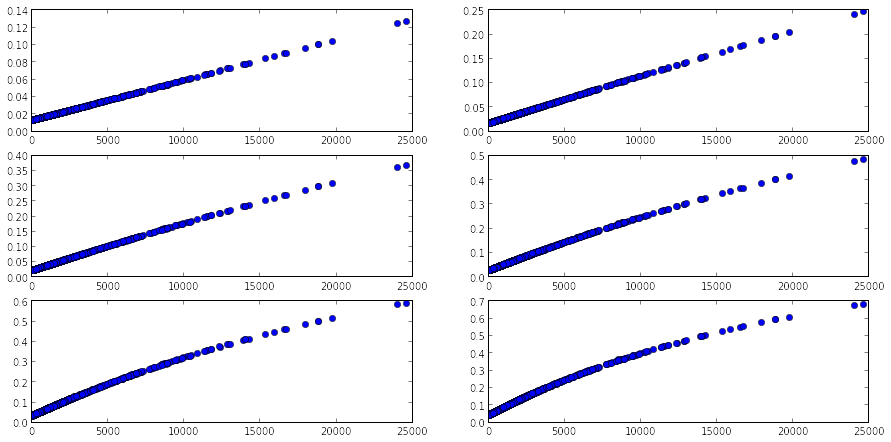

In [14]:
plt.figure(figsize=(15, 10))
for i in xrange(6):  
    params = np.load(os.path.join(save_dir, 'ExpoMF_K%d_mu%.1e_iter%d.npz' % (n_components, init_mu, i)))
    mu = params['mu']
    plt.subplot(4, 2, i+1)
    plt.plot(item_popularity, mu, 'o')
pass

## Evaluate the performance on heldout testset

In [15]:
n_params = len(glob.glob(os.path.join(save_dir, '*.npz')))

params = np.load(os.path.join(save_dir, 'ExpoMF_K%d_mu%.1e_iter%d.npz' % (n_components, init_mu, n_params - 1)))
U, V, mu = params['U'], params['V'], params['mu']

### Rank by $\theta_u^\top \beta_i$

In [16]:
print 'Test Recall@20: %.4f' % rec_eval.recall_at_k(train_data, test_data, U, V, k=20, vad_data=vad_data)
print 'Test Recall@50: %.4f' % rec_eval.recall_at_k(train_data, test_data, U, V, k=50, vad_data=vad_data)
print 'Test NDCG@100: %.4f' % rec_eval.normalized_dcg_at_k(train_data, test_data, U, V, k=100, vad_data=vad_data)
print 'Test MAP@100: %.4f' % rec_eval.map_at_k(train_data, test_data, U, V, k=100, vad_data=vad_data)

Test Recall@20: 0.2011
Test Recall@50: 0.2858
Test NDCG@100: 0.2630
Test MAP@100: 0.1092


### Rank by $\mathbb{E}[y_{ui}] = \mu_{i} \theta_u^\top\beta_i$

In [17]:
print 'Test Recall@20: %.4f' % rec_eval.recall_at_k(train_data, test_data, U, V, k=20, mu=mu, vad_data=vad_data)
print 'Test Recall@50: %.4f' % rec_eval.recall_at_k(train_data, test_data, U, V, k=50, mu=mu, vad_data=vad_data)
print 'Test NDCG@100: %.4f' % rec_eval.normalized_dcg_at_k(train_data, test_data, U, V, k=100, mu=mu, vad_data=vad_data)
print 'Test MAP@100: %.4f' % rec_eval.map_at_k(train_data, test_data, U, V, k=100, mu=mu, vad_data=vad_data)

Test Recall@20: 0.1506
Test Recall@50: 0.2377
Test NDCG@100: 0.2109
Test MAP@100: 0.0741
